In [ ]:
# Используемые библиотеки

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
# Визуализация городов на карте

lats = np.array([52.3727, 37.9841, 41.3827, 52.52, 47.4925, 38.7252, 51.5072, 48.8566, 41.8933, 48.2083])
lons = np.array([4.8957, 23.7280, 2.1769, 13.405, 19.0513, -9.15, -0.1275, 2.3522, 12.4827, 16.3725])
cities = np.array(["Amsterdam", "Athens", "Barcelona", "Berlin", "Budapest", "Lisbon", "London", "Paris", "Rome", "Vienna"])

location = list(zip(lats,lons))
popups = ["{}".format(cities) for (cities) in cities]
popups

m1 = folium.Map(
    location=[48.1375, 11.575],
    tiles='openstreetmap',
    zoom_start=5
)

marker_cluster = MarkerCluster(
    locations=location,
    popups=popups,
    name="1000 clustered icons",
    overlay=True,
    control=True
)


marker_cluster.add_to(m1)

folium.LayerControl().add_to(m1)

m1

In [ ]:
#Исследуемый город: Амстердам

df_am_1 = pd.read_csv('amsterdam_weekdays.csv')
df_am_2 = pd.read_csv('amsterdam_weekends.csv')


df = pd.concat([df_am_1, df_am_2])
df.insert(1, 'City', 'Amsterdam')
df = df.drop('Unnamed: 0', axis=1)
df.index = range(1, len(df) + 1)

In [ ]:
# Избавляемся от булевых значений

df["room_shared"] = df["room_shared"].astype(int)
df["room_private"] = df["room_private"].astype(int)
df["host_is_superhost"] = df["host_is_superhost"].astype(int)

print(set(df['room_type']))
room_type_to_number = {'Entire home/apt':0, 'Private room':1, 'Shared room':2}
df['room_type'] = df['room_type'].replace(room_type_to_number)
df

{'Shared room', 'Entire home/apt', 'Private room'}


,City,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
1,Amsterdam,194.033698,1,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
2,Amsterdam,344.245776,1,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
3,Amsterdam,264.101422,1,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
4,Amsterdam,433.529398,1,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
5,Amsterdam,485.552926,1,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,Amsterdam,473.132894,0,0,0,2.0,0,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629
2077,Amsterdam,491.645771,0,0,0,3.0,0,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412
2078,Amsterdam,1812.855904,0,0,0,4.0,0,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794
2079,Amsterdam,399.315727,0,0,0,2.0,0,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639


In [ ]:
# Разбиваем локацию на 10 кластеров
# Цель: Разбить на квадраты места с наибольшим количеством объектов аренды

coordinates = df[['lat', 'lng']]
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(coordinates)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Сводная таблица по кластерам.

pvt = np.round(df.pivot_table(
                index = 'cluster',
                aggfunc = {'City':'count', 'rest_index_norm':'median', 'attr_index_norm':'median', 'realSum':('max', 'mean')}
                ), 2)

pvt = pvt.rename(columns={'City':'Count', 'count':''})
pvt

Count attr_index_norm  realSum         rest_index_norm
                       median      max    mean          median
cluster                                                       
0         411           14.41  2175.61  664.81           26.81
1         228            8.47  2058.91  499.97           16.00
2          54            3.27  1210.60  398.75            6.35
3          87            5.49  8130.67  598.66            9.96
4         295           24.56  3638.13  672.27           50.20
5          81            2.62   940.41  334.78            4.94
6         453           20.02  3005.41  661.58           35.54
7          91            3.75   987.04  341.58            6.92
8         186            7.90  2486.58  482.99           14.64
9         194            6.80  1167.48  439.04           13.20

<Axes: title={'center': 'rest_index_norm'}, xlabel='cluster'>

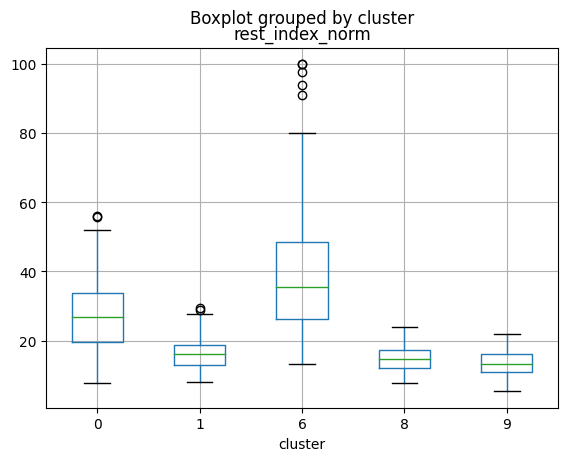

In [ ]:
# Boxplot данных об индексе ресторанов (rest_index_norm) по выбранным кластерам.
# Цель: Выбрать один кластер, где индекс ресторанов наименьший, чтобы выдержать конкуренцию.а

df.query('cluster == [0,1,6,8,9]').boxplot(column = 'rest_index_norm', by = 'cluster')

<Axes: title={'center': 'attr_index_norm'}, xlabel='cluster'>

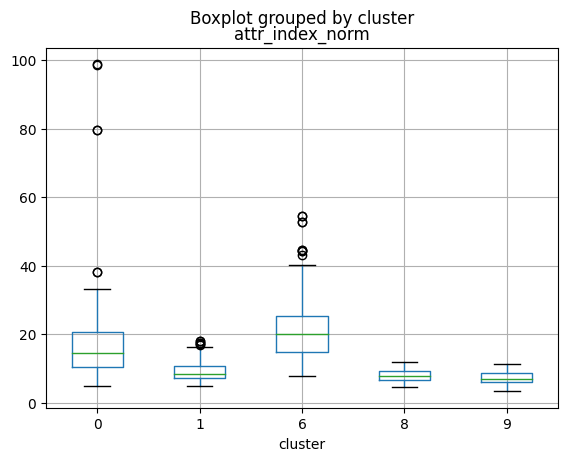

In [ ]:
# Boxplot данных по привлекательности района (attr_index) по выбранным кластерам.
# Цель: Выбрать один кластер, где район более привлекательный

df.query('cluster == [0,1,6,8,9]').boxplot(column = 'attr_index_norm', by = 'cluster')

In [ ]:
# Проверка на дубликаты
# 128 предложений совпадают. Большая часть дублируется выходные/будни. Однако есть предложения, находящиеся по одному адресу.
# Можно видеть по позиции 397 398, 437. Широта/долгота совпадают. Количество спален - нет.

duplicateRows1 = df[df.duplicated([
    'lng',
    #'lat'
])]
duplicateRows2 = duplicateRows1[duplicateRows1.duplicated([
    #'lng',
    'lat'
])]

duplicateRows2

,City,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,cluster
397,Amsterdam,855.341785,0,0,0,6.0,0,0,1,10.0,...,1,2.580980,0.823666,145.045704,7.680266,181.128995,12.621329,4.91000,52.39400,3
398,Amsterdam,675.837180,0,0,0,4.0,0,0,1,10.0,...,1,2.580977,0.823676,145.045846,7.680274,181.129054,12.621333,4.91000,52.39400,3
437,Amsterdam,968.293769,0,0,0,6.0,0,0,1,9.0,...,2,2.581013,0.823676,145.043987,7.680176,181.126738,12.621172,4.91000,52.39400,3
662,Amsterdam,313.312868,1,0,1,2.0,1,0,0,10.0,...,1,3.615053,2.341554,113.945025,6.033465,141.711839,9.874685,4.94600,52.37600,9
719,Amsterdam,251.915731,1,0,1,2.0,0,0,1,8.0,...,1,2.527532,0.339717,268.848216,14.235692,353.789620,24.652570,4.89075,52.35056,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,Amsterdam,283.786001,1,0,1,2.0,1,1,0,10.0,...,1,5.272025,0.739309,99.657586,5.276413,125.354934,10.927941,4.85800,52.33100,1
2048,Amsterdam,870.339559,1,0,1,4.0,1,1,0,10.0,...,2,0.619303,0.394440,518.285628,27.440851,956.478438,83.381960,4.89000,52.36800,4
2050,Amsterdam,356.431467,1,0,1,2.0,1,0,0,10.0,...,1,0.721172,0.218169,441.279504,23.363729,573.320786,49.979810,4.90369,52.37311,4
2052,Amsterdam,339.090291,1,0,1,4.0,0,0,0,9.0,...,1,2.849476,0.961915,152.597656,8.079347,191.424277,16.687602,4.85189,52.37769,8


In [ ]:
# Кластер №0

df_cluster_0 = df.query('cluster == 0')
df_cluster_0

,City,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,cluster
13,Amsterdam,675.602840,0,0,0,4.0,0,0,0,8.0,...,1,2.933046,0.628073,214.923342,11.380334,269.624904,18.787851,4.88934,52.34697,0
17,Amsterdam,368.851499,1,0,1,2.0,0,0,0,10.0,...,1,1.327797,0.119528,539.012884,28.541090,573.896572,39.989939,4.88971,52.36148,0
27,Amsterdam,295.034331,1,0,1,2.0,0,1,0,10.0,...,1,3.366019,0.225882,170.028697,9.003133,217.155231,15.131689,4.89500,52.34300,0
32,Amsterdam,599.676611,0,0,0,4.0,0,0,0,9.0,...,3,3.363591,0.697422,156.237115,8.272859,198.874121,13.857835,4.90806,52.34442,0
37,Amsterdam,310.969465,0,0,0,2.0,0,1,0,9.0,...,0,4.147087,0.038355,118.778885,6.289421,151.376393,10.548125,4.92058,52.33997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,Amsterdam,372.600942,1,0,1,2.0,0,1,0,10.0,...,1,3.081543,0.496081,189.216620,10.018154,249.254482,21.729008,4.89596,52.34559,0
2060,Amsterdam,755.981534,0,0,0,4.0,0,0,0,9.0,...,3,2.010832,0.565089,270.987953,14.347571,352.973082,30.770780,4.90325,52.35626,0
2074,Amsterdam,405.642912,1,0,1,4.0,1,0,0,10.0,...,1,2.169236,0.212117,224.435844,11.882850,291.789702,25.437058,4.91118,52.35718,0
2078,Amsterdam,1812.855904,0,0,0,4.0,0,0,0,8.0,...,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794,0


In [ ]:
# Визуализация выбранного кластера на карте


location_cl0 = list(zip(np.array(df_cluster_0['lat']),np.array(df_cluster_0['lng'])))
location_all = list(zip(np.array(df['lat']),np.array(df['lng'])))
popups_cl0 = ["lng:{}<br>lat:{}".format(lng, lat) for (lng, lat) in location_cl0]
popups_all = ["lng:{}<br>lat:{}".format(lng, lat) for (lng, lat) in location_all]


m2 = folium.Map(
    location=[48.1375, 11.575],
    tiles='openstreetmap',
    zoom_start=5
)

marker_cluster_cl0 = MarkerCluster(
    locations=location_cl0,
    popups=popups_cl0,
    name="cluster 0",
    overlay=True,
    control=True
)

marker_cluster_all = MarkerCluster(
    locations=location_all,
    popups=popups_all,
    name="all data",
    overlay=True,
    control=True
)

marker_cluster_cl0.add_to(m2)
marker_cluster_all.add_to(m2)

folium.LayerControl().add_to(m2)

m2

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(25, 25))

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x790d602e52d0> (for post_execute):


KeyboardInterrupt: ignored

<Axes: xlabel='realSum', ylabel='attr_index_norm'>

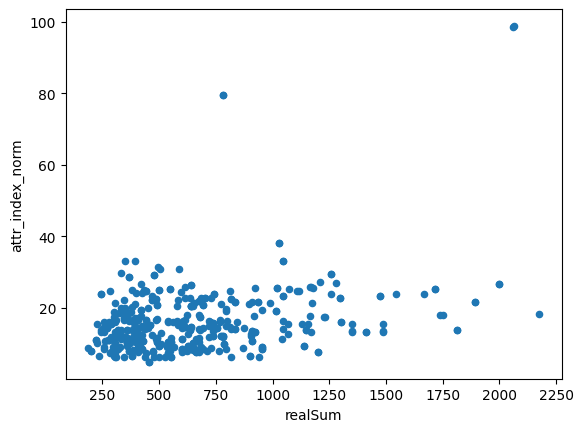

In [ ]:
# Диаграмма рассеивания для стоимости проживания и индексом привлекательности района.
df_cluster_0.plot('realSum', 'attr_index_norm', kind='scatter')
# Видим, что в данном кластере цена на аренду низкая и ближе к среднему, район средней привлекательности.

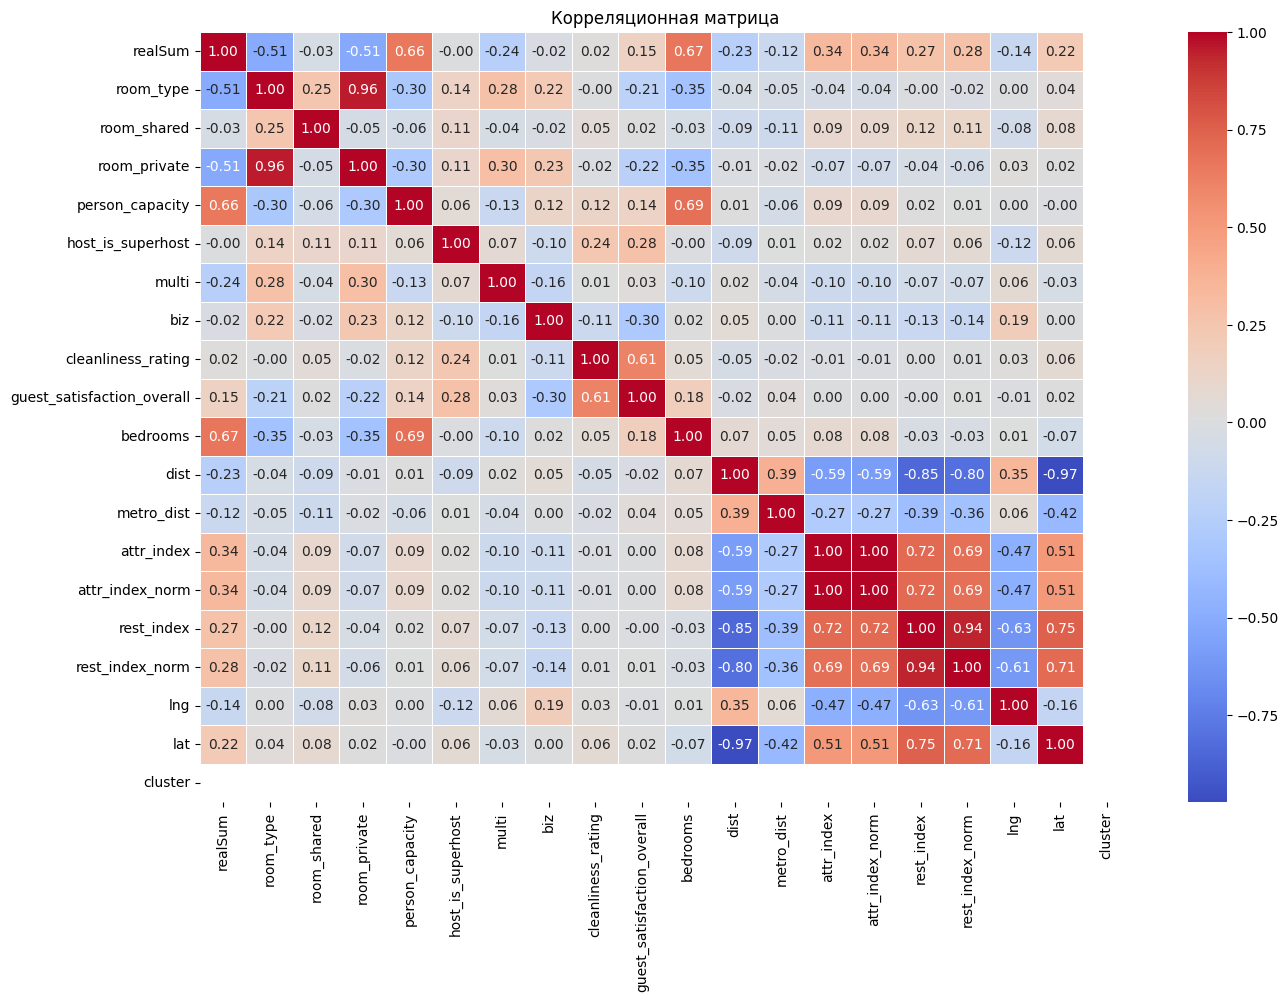

In [ ]:
#Корреляционная матрица между переменными датасета.
correlation_matrix = df_cluster_0.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

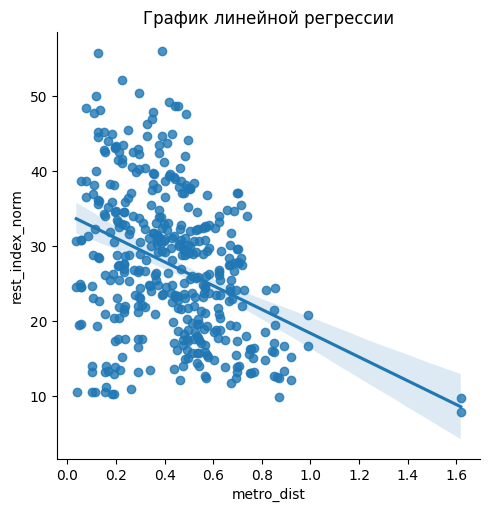

In [ ]:
# Линейная регрессия
# Цель: Понять Индекс ресторанов при удалении от центра города и определить окончательно район для открытия ресторана
sns.lmplot(x='metro_dist', y='rest_index_norm', data=df_cluster_0)
plt.title("График линейной регрессии")
plt.show()